Student Name:
Elad Prager

Academic institution:
Reichman University

Degree:
M.Sc. in Computer Science

Course:
Neural Language Models

# Part 1

## Summarization Quality

The task of masked language modeling involves obscuring certain words within a sentence and subsequently determining the appropriate replacements for those obscured words. In the first stage of the project, I've implement this task on a given document, and I've suggested that by incorporating a prefix of the document summarization, the task's performance on the concatenated summary and document will improve when compared to its application on the document alone. The rationale for this hypothesis is that the summary, being a concise representation of the document, would provide additional context to the task, thereby facilitating more accurate predictions for the obscured words. Additionally, it is expected that if the summary were to more effectively capture the essence of the document, the prediction of the model would be more accurate. If this hypothesis is upheld, it could potentially serve as a new metric for evaluating the quality of summaries.

### Initial imports

In [ ]:
!pip install wandb
!pip install datasets
!pip install transformers
!pip install trl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 6.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=cca2da9b88bc4e5c9c3d2e03b6906fb973decff8b1f14cf34dcb80a7f3d4eed4
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking 

In [ ]:
import torch
import wandb
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
tqdm.pandas()
from datasets import load_dataset
from transformers import GPT2Tokenizer, AutoModelForSequenceClassification, PegasusTokenizer, PegasusForConditionalGeneration, BertTokenizer, BertForMaskedLM, BertModel, pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForTokenClassification
from trl.gpt2 import GPT2HeadWithValueModel, respond_to_batch
from trl.ppo import PPOTrainer
from trl.core import build_bert_batch_from_txt
from pprint import pprint
import random
from operator import itemgetter
import spacy
from random import randrange
from statistics import mean

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
from google.colab import drive
from IPython.display import Image
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset

In [ ]:
dataset_comparison = load_dataset("openai/summarize_from_feedback", 'comparisons')

Extracting data files:   0%|          | 0/23 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset summarize_from_feedback downloaded and prepared to /root/.cache/huggingface/datasets/openai___summarize_from_feedback/comparisons/0.0.0/483f970ceb55b926b0a087ef4f678ab1b089bc8174a107a452c6152e88af7ff0. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
len(dataset_comparison['train'])

92858

In [ ]:
len(dataset_comparison['validation'])

86086

### Comparison dataset - Dataset overview

In [ ]:
dataset_comparison['train']['info'][1]

{'id': 't3_34xale',
 'post': "My boyfriend and I are long distance. We have a trip planned this summer which involves me going over to him in the USA. This will be the second time I have actually been with him in person. I am flying from the UK with my mum to the east coast. The original plan was for me to fly over to my boyfriend in the west coast (my parents are holidaying on the east coast) but because my mum was freaking out so much about me going to meet my boyfriend i said we can all road trip there together. I even invited her on the trip with us. I have given her all of our dates so that she can travel around with us.\n\nThe plan was for me to stay on the 4th July and fly back on the 5th. Mum knew this. I told her I had booked a flight back already from the west coast to east coast (where she would pick me up and we would fly back to the UK together). She has gone mad at me because she can't believe I would book a flight when she told me she didn't want me flying on my own. At 

In [ ]:
dataset_comparison['train']['summaries'][1]

[{'text': ' I have made sure my mother is comfortable with my boyfriend travelling on a trip and now my mother is mad because I booked it.',
  'policy': 'sup1',
  'note': None},
 {'text': " mum isn't speaking to me because I booked a flight and she doesn't want me flying on my own.",
  'policy': 'ref',
  'note': None}]

In [ ]:
dataset_comparison['train']['choice'][1]

1

### Comparison dataset - Get documents and summaries groups

In [ ]:
documents = [features['info']['post'] for features in dataset_comparison['train']]
doc_length = [len(x)for x in documents]

summaries_A = [features['summaries'][0]['text'] if features['choice']==0 else features['summaries'][1]['text'] for features in dataset_comparison['train']]
summaries_B = [features['summaries'][1]['text'] if features['choice']==0 else features['summaries'][0]['text'] for features in dataset_comparison['train']]

As the hypothesis proposed, it is anticipated that if the summary effectively captures the essence of the document as in the "summaries_A" summarization group, the prediction of the model will be more accurate compared to the "summaries_B" summarization group. Furthermore, it is expected that the task's performance on the concatenated summaries and documents will be superior when compared to its application on the documents alone.

Let's sort the given data based on the documents length

In [ ]:
sorted_zip = [list(x) for x in zip(*sorted(zip(doc_length, documents, summaries_A, summaries_B), key=itemgetter(0)))]

In [ ]:
documents = sorted_zip[1][50:]
summaries_A = sorted_zip[2][50:]
summaries_B = sorted_zip[3][50:]

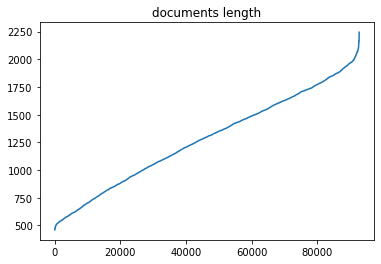

In [ ]:
len_documents = [len(x) for x in documents]
plt.plot(len_documents)
plt.title('documents length')
plt.show()

In [ ]:
print(f'documents len: {len(documents)}')
print(f'summaries_A len: {len(summaries_A)}')
print(f'summaries_B len: {len(summaries_B)}')

documents len: 92808
summaries_A len: 92808
summaries_B len: 92808


### Mask document

In this process, a random word in the given document will be obscured, with the constraint that the masked word shall not be:
1.   a stopped word
2.   the initial word of the document
3.   a numeric value.

Of course, this method can be further improved by implementing additional logical constraints.





In [ ]:
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words
print(stop_words)
print(f'num of stop words: {len(stop_words)}')

{'least', 'within', 'no', 'it', 'last', 'only', 'himself', 'at', 'something', 'become', 'used', 'ca', 'since', 'when', 'thus', 'six', 'why', 'ten', 'nothing', 'would', "n't", 'herein', 'someone', 'being', '‘m', 'put', 'now', 'became', 'twelve', 'was', 'after', 'nowhere', 'be', 'few', 'often', 'alone', 'really', 'off', 'onto', 'is', 'have', 'call', '’d', 'we', '‘re', 'our', 'themselves', 'somewhere', 'along', "'re", 'most', 'upon', 'me', 'did', 'during', 'whereby', 'who', 'whence', 'cannot', 'those', 'how', 'hereafter', 'can', 'however', 'see', 'whoever', 'well', 'are', 'nobody', 'third', 'until', 'top', 'do', 'with', 'though', 'any', 'four', 'hereby', '‘ll', 'formerly', 'first', 'eleven', 'had', 'per', '’ve', 'yet', 'else', 'done', 'less', 'has', 'should', '’s', 'almost', 'whatever', 'nine', 'over', 'throughout', 'otherwise', 'what', 'besides', 'these', 'thereby', 'all', 'up', 'us', 'must', 'except', 'latterly', 'for', 'either', 'an', 'herself', 'everything', 'behind', 'latter', 'go', 

In [ ]:
def get_masked_documents(documents):
  documents_masked_words = []
  documents_masked = []

  for i, document in enumerate(documents):
    valid_for_masking = False
    mask_index = 1

    document_masked_words = []
    document_words = document.split()
    
    while not valid_for_masking:
      mask_index = randrange(len(document_words))
      mask_word = document_words[mask_index].lower()
      valid_for_masking = mask_word not in stop_words and mask_index!=0 and not mask_word.isnumeric()

    document_words[mask_index] = '[MASK]'
    document_masked_words = mask_word

    document_masked = " ".join(document_words)

    documents_masked.append(document_masked)
    documents_masked_words.append(document_masked_words)
  return documents_masked, documents_masked_words 

In [ ]:
documents_masked, documents_masked_words  = get_masked_documents(documents)

In [ ]:
print(f'documents_masked len: {len(documents_masked)}')
print(f'documents_masked_words len: {len(documents_masked_words)}')

documents_masked len: 92808
documents_masked_words len: 92808


### Comparison dataset - Concatenate summaries with documents

In [ ]:
summary_A_concat_document = []
summary_B_concat_document = []

for i, document in enumerate(documents_masked):
  summary_A_concat_document.append(summaries_A[i] + '\n' + document)
  summary_B_concat_document.append(summaries_B[i] + '\n' + document)

In [ ]:
print(f'summary_A_concat_document len: {len(summary_A_concat_document)}')
print(f'summary_B_concat_document len: {len(summary_B_concat_document)}')

summary_A_concat_document len: 92808
summary_B_concat_document len: 92808


### Comparison dataset - Sanity check

In [ ]:
pprint(documents[25])

('She broke up with me 2 weeks ago, I have barely told anyone yet. She broke '
 'up with me early on in the relationship but she came back after a couple '
 'days, later she said she had wished i made an attempt to get her back. '
 "immature of the time, and this time around I don't think I will get her "
 'back, but i want to put in a little effort just to make her feel like she '
 'mattered to me. I was thinking of just putting a rose on her car for when '
 'she gets out of work and call it good')


In [ ]:
pprint(documents_masked[25])

('She broke up with me 2 weeks ago, I have barely told anyone yet. She broke '
 'up with me early on in the relationship but she came back after a couple '
 'days, later she said she had wished i made an attempt to get her back. '
 "immature of the time, and this time around I don't think I will get her "
 'back, but i want to put in a little [MASK] just to make her feel like she '
 'mattered to me. I was thinking of just putting a rose on her car for when '
 'she gets out of work and call it good')


In [ ]:
documents_masked_words[25]

'effort'

In [ ]:
summaries_A[25]

' GF broke up with me but came back a couple days later, I want to keep a rose on her car as a little gesture to show her that I still care, and I think it would be kinder for her to see it.'

In [ ]:
pprint(summary_A_concat_document[25])

(' GF broke up with me but came back a couple days later, I want to keep a '
 'rose on her car as a little gesture to show her that I still care, and I '
 'think it would be kinder for her to see it.\n'
 'She broke up with me 2 weeks ago, I have barely told anyone yet. She broke '
 'up with me early on in the relationship but she came back after a couple '
 'days, later she said she had wished i made an attempt to get her back. '
 "immature of the time, and this time around I don't think I will get her "
 'back, but i want to put in a little [MASK] just to make her feel like she '
 'mattered to me. I was thinking of just putting a rose on her car for when '
 'she gets out of work and call it good')


In [ ]:
pprint(summary_B_concat_document[25])

(' gf broke up with me, I want to make an effort just to make her feel '
 'better.\n'
 'She broke up with me 2 weeks ago, I have barely told anyone yet. She broke '
 'up with me early on in the relationship but she came back after a couple '
 'days, later she said she had wished i made an attempt to get her back. '
 "immature of the time, and this time around I don't think I will get her "
 'back, but i want to put in a little [MASK] just to make her feel like she '
 'mattered to me. I was thinking of just putting a rose on her car for when '
 'she gets out of work and call it good')


### load pipeline

In [ ]:
unmasker = pipeline('fill-mask', "bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Comparison dataset - Fill masks in 3 methods (document only, summary_A prefix, summary_B prefix)

In [ ]:
documents_fill_mask_words = []

document_fill_mask = [unmasker(x) for x in documents_masked[:2500]]
for document in document_fill_mask:

  max_mask = max([mask['score'] for mask in document])
  filled_token = [mask['token_str'].replace(" ", "") for mask in document if mask['score'] == max_mask][0]

  documents_fill_mask_words.append(filled_token)

In [ ]:
summaries_A_fill_mask_words = []

summary_A_fill_mask = [unmasker(x) for x in summary_A_concat_document[:2500]]
for document in summary_A_fill_mask:

  max_mask = max([mask['score'] for mask in document])
  filled_token = [mask['token_str'].replace(" ", "") for mask in document if mask['score'] == max_mask][0]

  summaries_A_fill_mask_words.append(filled_token)

In [ ]:
summaries_B_fill_mask_words = []

summary_B_fill_mask = [unmasker(x) for x in summary_B_concat_document[:2500]]
for document in summary_B_fill_mask:

  max_mask = max([mask['score'] for mask in document])
  filled_token = [mask['token_str'].replace(" ", "") for mask in document if mask['score'] == max_mask][0]

  summaries_B_fill_mask_words.append(filled_token)

### Comparison dataset - Evaluation

In [ ]:
df = pd.DataFrame({
    'summaries_A': summaries_A_fill_mask_words[:30], 
    'summaries_B': summaries_B_fill_mask_words[:30],
    'documents': documents_fill_mask_words[:30],
    'original_word': documents_masked_words[:30]
})
df

summaries_A    summaries_B      documents  original_word
0           stuck          stuck          stuck          stuck
1            girl           girl           girl      one-upper
2           house          house          house          house
3           house          house          house          house
4            comb           comb           comb            dad
5           crazy          crazy          crazy         bright
6            girl           girl           girl      one-upper
7           crazy          crazy          crazy         bright
8         officer          adult        officer          adult
9           terms          terms          terms         terms.
10        forward        forward        forward        forward
11              ,              ,              ,           he's
12           like           like           like          with.
13  relationships  relationships  relationships  relationships
14           days           days           days           days
15              .              .              .         stuff.
16          years          years          years        months,
17           drop           drop           drop           drop
18           pick           pick           pick           pick
19          asked          asked          asked        offered
20          years          years          years          weeks
21            ago            and            and           ago,
22          broke          broke          broke          broke
23           gets           gets           gets           gets
24            two            two            two          time,
25            not            not            not         barely
26           came           came           came           came
27         effort         effort         effort        attempt
28        belongs        belongs        belongs       mattered
29         effort         effort         effort        attempt

In [ ]:
def get_accuracy(document):
  accuracies = []

  for i, w in enumerate(document):
    is_correct = 0
    if w == documents_masked_words[i]:
      is_correct = 1
    accuracies.append(is_correct)
  mean_accuracy = mean(accuracies)
  return mean_accuracy

In [ ]:
acc_summaries_A = get_accuracy(summaries_A_fill_mask_words)
print(f'concat_summary_A: {acc_summaries_A*100}%')

acc_summaries_B = get_accuracy(summaries_B_fill_mask_words)
print(f'concat_summary_B: {acc_summaries_B*100}%')

acc_baseline = get_accuracy(documents_fill_mask_words)
print(f'masked_document_only: {acc_baseline*100}%')

concat_summary_A: 31.56%
concat_summary_B: 31.080000000000002%
masked_document_only: 29.599999999999998%


<BarContainer object of 3 artists>

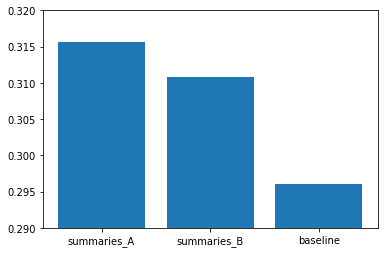

In [ ]:
x = ['summaries_A','summaries_B','baseline']
y = [acc_summaries_A, acc_summaries_B, acc_baseline]
plt.ylim(0.29, 0.32)
plt.bar(x, y)

### Axis dataset

In [ ]:
dataset_axis = load_dataset("openai/summarize_from_feedback", 'axis')

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset summarize_from_feedback downloaded and prepared to /root/.cache/huggingface/datasets/openai___summarize_from_feedback/axis/0.0.0/483f970ceb55b926b0a087ef4f678ab1b089bc8174a107a452c6152e88af7ff0. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

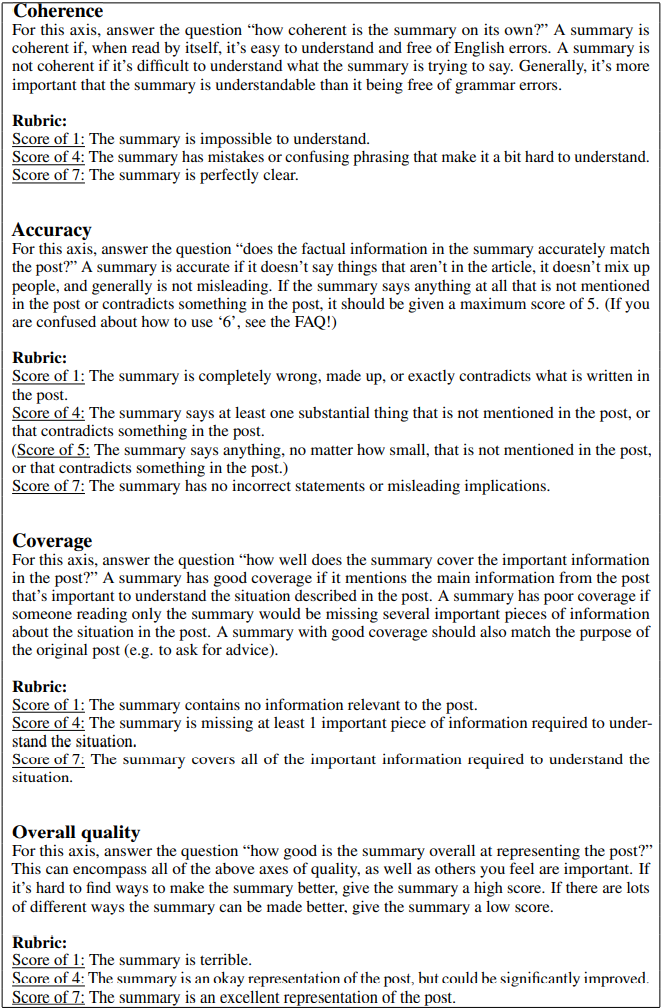

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure10.PNG', width="600")

In [ ]:
len(dataset_axis['validation'])

8585

In [ ]:
len(dataset_axis['test'])

6312

Axis dataset - Dataset overview

In [ ]:
dataset_axis['validation']['info'][100]

{'id': 't3_20uf3g',
 'post': "I was at a local cafe and saw a girl I went to high school with, but never got to know her. I believe she was a grade below me. I always thought she was pretty, but I've never had the balls to go up and ask a girl out. The same can be said in this situation.. She was there for about an hour and we never spoke a word, but she did look at me a few times.\n\nWould it be creepy if I found her on Facebook and asked her out/started talking to her? I have no idea what her name is, but I'm sure I can find her in a yearbook. What's your opinion on this, reddit?",
 'title': 'Would it be creepy to do this? [21,M]',
 'subreddit': 'relationships',
 'site': None,
 'article': None}

In [ ]:
dataset_axis['validation']['summary'][100]

{'text': ' Saw a girl I went to highschool with at a local cafe, but never got around to talking to her. Would it be creepy if I found her on facebook and started chatting/asked her out?',
 'policy': 'ref',
 'note': 'Summary is good. ',
 'axes': {'overall': 7,
  'accuracy': 7,
  'coverage': 7,
  'coherence': 7,
  'compatible': None}}

In [ ]:
dataset_axis['validation']['info'][101]

{'id': 't3_20uf3g',
 'post': "I was at a local cafe and saw a girl I went to high school with, but never got to know her. I believe she was a grade below me. I always thought she was pretty, but I've never had the balls to go up and ask a girl out. The same can be said in this situation.. She was there for about an hour and we never spoke a word, but she did look at me a few times.\n\nWould it be creepy if I found her on Facebook and asked her out/started talking to her? I have no idea what her name is, but I'm sure I can find her in a yearbook. What's your opinion on this, reddit?",
 'title': 'Would it be creepy to do this? [21,M]',
 'subreddit': 'relationships',
 'site': None,
 'article': None}

In [ ]:
dataset_axis['validation']['summary'][101]

{'text': ' I had never spoken to this girl as a teenager, but she looked at me a few times. What do you think?',
 'policy': 'pretrain_6b_t.7',
 'note': 'Missing the real dilemma of OP. Also, the details are vague. ',
 'axes': {'overall': 2,
  'accuracy': 6,
  'coverage': 2,
  'coherence': 4,
  'compatible': None}}

### Axis dataset - Get documents and summaries

In [ ]:
axis_documents = [features['post'] for features in dataset_axis['validation']['info']]
axis_doc_length = [len(x)for x in axis_documents]

overall_7 = [features['text'] if features['axes']['overall']==7 else None for features in dataset_axis['validation']['summary']]
overall_6 = [features['text'] if features['axes']['overall']==6 else None for features in dataset_axis['validation']['summary']]
overall_5 = [features['text'] if features['axes']['overall']==5 else None for features in dataset_axis['validation']['summary']]
overall_4 = [features['text'] if features['axes']['overall']==4 else None for features in dataset_axis['validation']['summary']]
overall_3 = [features['text'] if features['axes']['overall']==3 else None for features in dataset_axis['validation']['summary']]
overall_2 = [features['text'] if features['axes']['overall']==2 else None for features in dataset_axis['validation']['summary']]
overall_1 = [features['text'] if features['axes']['overall']==1 else None for features in dataset_axis['validation']['summary']]

Let's sort the given data based on the documents length

In [ ]:
axis_sorted_zip = [list(x) for x in zip(*sorted(zip(axis_doc_length, axis_documents, overall_7, overall_6, overall_5, overall_4, overall_3, overall_2, overall_1), key=itemgetter(0)))]

In [ ]:
axis_documents = axis_sorted_zip[1][50:]
overall_7 = axis_sorted_zip[2][50:]
overall_6 = axis_sorted_zip[3][50:]
overall_5 = axis_sorted_zip[4][50:]
overall_4 = axis_sorted_zip[5][50:]
overall_3 = axis_sorted_zip[6][50:]
overall_2 = axis_sorted_zip[7][50:]
overall_1 = axis_sorted_zip[8][50:]

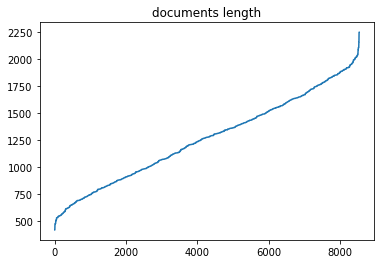

In [ ]:
len_axis_documents = [len(x) for x in axis_documents]
plt.plot(len_axis_documents)
plt.title('documents length')
plt.show()

In [ ]:
print(f'axis_documents: {len(axis_documents)}')
print(f'overall_7: {len(overall_7)}')
print(f'overall_6: {len(overall_6)}')
print(f'overall_5: {len(overall_5)}')
print(f'overall_4: {len(overall_4)}')
print(f'overall_3: {len(overall_3)}')
print(f'overall_2: {len(overall_2)}')
print(f'overall_1: {len(overall_1)}')

axis_documents: 8535
overall_7: 8535
overall_6: 8535
overall_5: 8535
overall_4: 8535
overall_3: 8535
overall_2: 8535
overall_1: 8535


In [ ]:
axis_documents_masked, axis_documents_masked_words  = get_masked_documents(axis_documents)

In [ ]:
print(f'axis_documents_masked len: {len(axis_documents_masked)}')
print(f'axis_documents_masked_words len: {len(axis_documents_masked_words)}')

axis_documents_masked len: 8535
axis_documents_masked_words len: 8535


### Axis dataset - Concatenate summaries with documents

In [ ]:
overall_7_concat_document = []
overall_6_concat_document = []
overall_5_concat_document = []
overall_4_concat_document = []
overall_3_concat_document = []
overall_2_concat_document = []
overall_1_concat_document = []

for i, axis_document in enumerate(axis_documents_masked):
  overall_7_concat_document.append(overall_7[i] + '\n' + axis_document) if overall_7[i] != None else overall_7_concat_document.append(None)
  overall_6_concat_document.append(overall_6[i] + '\n' + axis_document) if overall_6[i] != None else overall_6_concat_document.append(None)
  overall_5_concat_document.append(overall_5[i] + '\n' + axis_document) if overall_5[i] != None else overall_5_concat_document.append(None)
  overall_4_concat_document.append(overall_4[i] + '\n' + axis_document) if overall_4[i] != None else overall_4_concat_document.append(None)
  overall_3_concat_document.append(overall_3[i] + '\n' + axis_document) if overall_3[i] != None else overall_3_concat_document.append(None)
  overall_2_concat_document.append(overall_2[i] + '\n' + axis_document) if overall_2[i] != None else overall_2_concat_document.append(None)
  overall_1_concat_document.append(overall_1[i] + '\n' + axis_document) if overall_1[i] != None else overall_1_concat_document.append(None)

In [ ]:
print(f'overall_7_concat_document len: {len(overall_7_concat_document)}')
print(f'overall_6_concat_document len: {len(overall_6_concat_document)}')
print(f'overall_5_concat_document len: {len(overall_5_concat_document)}')
print(f'overall_4_concat_document len: {len(overall_4_concat_document)}')
print(f'overall_3_concat_document len: {len(overall_3_concat_document)}')
print(f'overall_2_concat_document len: {len(overall_2_concat_document)}')
print(f'overall_1_concat_document len: {len(overall_1_concat_document)}')

overall_7_concat_document len: 8535
overall_6_concat_document len: 8535
overall_5_concat_document len: 8535
overall_4_concat_document len: 8535
overall_3_concat_document len: 8535
overall_2_concat_document len: 8535
overall_1_concat_document len: 8535


### Axis dataset - Sanity check

In [ ]:
axis_documents_masked_words[18]

'friends'

In [ ]:
pprint(axis_documents[18])

("So there's a guy at my work that I've talked to occasionally. He seems "
 'really cool and he just moved here from another state.\n'
 '\n'
 "I've had a hard time making friends with other people at work since most in "
 'my department are a lot older and have kids and families.\n'
 '\n'
 "I'm also considering a move to another department eventually and I'd like to "
 'have some allies at work for when that happens. How to I make friends with '
 'him without it seeming like in interested in more than that?')


In [ ]:
overall_7[18]

" I want to make friends with a guy at work without it seeming like I'm interested in more than just friendship. How to I do that?"

In [ ]:
pprint(overall_7_concat_document[18])

(" I want to make friends with a guy at work without it seeming like I'm "
 'interested in more than just friendship. How to I do that?\n'
 "So there's a guy at my work that I've talked to occasionally. He seems "
 "really cool and he just moved here from another state. I've had a hard time "
 'making [MASK] with other people at work since most in my department are a '
 "lot older and have kids and families. I'm also considering a move to another "
 "department eventually and I'd like to have some allies at work for when that "
 'happens. How to I make friends with him without it seeming like in '
 'interested in more than that?')


In [ ]:
overall_7_concat_document_valid = [x for x in overall_7_concat_document[:2500] if x != None]
overall_6_concat_document_valid = [x for x in overall_6_concat_document[:2500] if x != None]
overall_5_concat_document_valid = [x for x in overall_5_concat_document[:2500] if x != None]
overall_4_concat_document_valid = [x for x in overall_4_concat_document[:2500] if x != None]
overall_3_concat_document_valid = [x for x in overall_3_concat_document[:2500] if x != None]
overall_2_concat_document_valid = [x for x in overall_2_concat_document[:2500] if x != None]
overall_1_concat_document_valid = [x for x in overall_1_concat_document[:2500] if x != None]

print(f'overall_7_valid_summaries length: {len(overall_7_concat_document_valid)}')
print(f'overall_6_valid_summaries length: {len(overall_6_concat_document_valid)}')
print(f'overall_5_valid_summaries length: {len(overall_5_concat_document_valid)}')
print(f'overall_4_valid_summaries length: {len(overall_4_concat_document_valid)}')
print(f'overall_3_valid_summaries length: {len(overall_3_concat_document_valid)}')
print(f'overall_2_valid_summaries length: {len(overall_2_concat_document_valid)}')
print(f'overall_1_valid_summaries length: {len(overall_1_concat_document_valid)}')

overall_7_valid_summaries length: 508
overall_6_valid_summaries length: 482
overall_5_valid_summaries length: 429
overall_4_valid_summaries length: 527
overall_3_valid_summaries length: 279
overall_2_valid_summaries length: 180
overall_1_valid_summaries length: 85


Based on the varying length of each group, it was determined that a comparison of groups with similar length would be more appropriate. As such, the "overall_7" and "overall_4" groups were selected for further experimentation.<br><br>As the hypothesis proposed, it is anticipated that if the summary effectively captures the essence of the document as in the "overall_7" summarization group, the prediction of the model will be more accurate compared to the "overall 4" summarization group. Furthermore, it is expected that the task's performance on the concatenated summaries and documents will be superior when compared to its application on the documents alone.

### Axis dataset - Fill masks in 3 methods (document only, overall_7 prefix, overall_4 prefix)

In [ ]:
axis_documents_fill_mask_words = []

axis_documents_fill_mask = [unmasker(x) for x in axis_documents_masked[:500]]
for document in axis_documents_fill_mask:

  max_mask = max([mask['score'] for mask in document])
  filled_token = [mask['token_str'].replace(" ", "") for mask in document if mask['score'] == max_mask][0]

  axis_documents_fill_mask_words.append(filled_token)

In [ ]:
overall_7_fill_mask_words = []

overall_7_fill_mask = [unmasker(x) if x != None else None for x in overall_7_concat_document[:2500]]
for document in overall_7_fill_mask:
  if document != None:
    max_mask = max([mask['score'] for mask in document])
    filled_token = [mask['token_str'].replace(" ", "") for mask in document if mask['score'] == max_mask][0]
  else:
    filled_token = None
  overall_7_fill_mask_words.append(filled_token)

In [ ]:
overall_4_fill_mask_words = []

overall_4_fill_mask = [unmasker(x) if x != None else None for x in overall_4_concat_document[:2500]]
for document in overall_4_fill_mask:
  if document != None:
    max_mask = max([mask['score'] for mask in document])
    filled_token = [mask['token_str'].replace(" ", "") for mask in document if mask['score'] == max_mask][0]
  else:
    filled_token = None
  overall_4_fill_mask_words.append(filled_token)

### Axis dataset - Evaluation

In [ ]:
df = pd.DataFrame({
    'overall_4': overall_4_fill_mask_words[:30],
    'overall_7': overall_7_fill_mask_words[:30],
    'axis_documents': axis_documents_fill_mask_words[:30],
    'original_word': axis_documents_masked_words[:30]
})
df

overall_4 overall_7 axis_documents original_word
0         None      None          touch       contact
1         None      None        started       entered
2         None      None              .  psychologist
3         None      None       replaced      adjusted
4         None      None           said          said
5         None      None          speak         speak
6         None      None     medication   medication.
7         None      None        offered        agreed
8         None      None      apologize     apologize
9         None      None          bring           dig
10        None         ?              ?     memories?
11        None      None             we         we're
12        None      None             we         we're
13        None      None          going         going
14  girlfriend      None           wife    girlfriend
15        None      None         friend     co-worker
16        None      None             is      happens.
17          or      None             or    interested
18        None   friends        friends       friends
19        None      None     department    department
20        None      time           time          time
21       moved      None          moved         moved
22        None      None     department        state.
23        None      None        friends       friends
24        None     never          never         don't
25        None         ,              ,      strictly
26        None     never          never         don't
27        None     house          house         house
28        None      None              ,      strictly
29        None      good           good     emotional

In [ ]:
def axis_get_accuracy(document):
  accuracies = []

  for i, w in enumerate(document):
    if w == None:
      continue
    is_correct = 0
    if w == axis_documents_masked_words[i]:
      is_correct = 1
    accuracies.append(is_correct)
  mean_accuracy = mean(accuracies)
  return mean_accuracy

In [ ]:
acc_overall_7 = axis_get_accuracy(overall_7_fill_mask_words)
print(f'concat_overall_7: {acc_overall_7*100}%')

acc_overall_4 = axis_get_accuracy(overall_4_fill_mask_words)
print(f'concat_overall_4: {acc_overall_4*100}%')

acc_baseline = axis_get_accuracy(axis_documents_fill_mask_words)
print(f'masked_document_only: {acc_baseline*100}%')

concat_overall_7: 31.69291338582677%
concat_overall_4: 29.601518026565465%
masked_document_only: 26.400000000000002%


<BarContainer object of 3 artists>

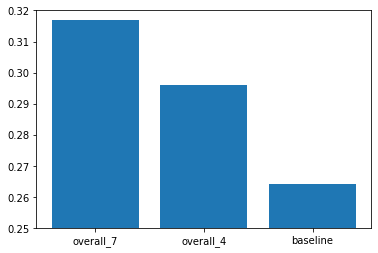

In [ ]:
x = ['overall_7','overall_4','baseline']
y = [acc_overall_7, acc_overall_4, acc_baseline]
plt.ylim(0.25, 0.32)
plt.bar(x, y)

### Future Work

* Try different approaches for masking words
* Compare to known evaluation techniques (ROUGE, etc.)
* Experiment on the entire comparison dataset
* Experiment on several new datasets
* Experiment with question answering

# Part 2

## Controlled Text Generation

Controlled text generation is the task of creating natural language text that **follows specific input or constraints**, such as a particular **style, tone** or specific words or **phrases**, it can be useful in various applications like  content **generation for social media or marketing**, etc. With **recent advances** in machine learning techniques like language models, and **reinforcement learning** algorithms, have led to significant progress in the field of controlled text generation, these models are able to learn from large amounts of data and generate text that is more human-like and natural than previous methods.

### Learning to summarize from human feedback

**The paper** "Learning to summarize from human feedback" presents a method of training a machine learning model to generate text summaries by **combining supervised learning with reinforcement learning**. The model is trained on a dataset of text documents and their corresponding human-written summaries. The model generates a summary and it is evaluated by a human annotator who **provides a reward signal** indicating how well the summary captures the main points of the document. This **feedback is used by the model to adjust its internal parameters** and generate better summaries in the future. The authors show that their approach generates high-quality summaries and **outperforms other methods** that don't use human feedback. Additionally the model **can learn from a small amount of feedback** and can generate summaries for unseen documents.

### Pipeline

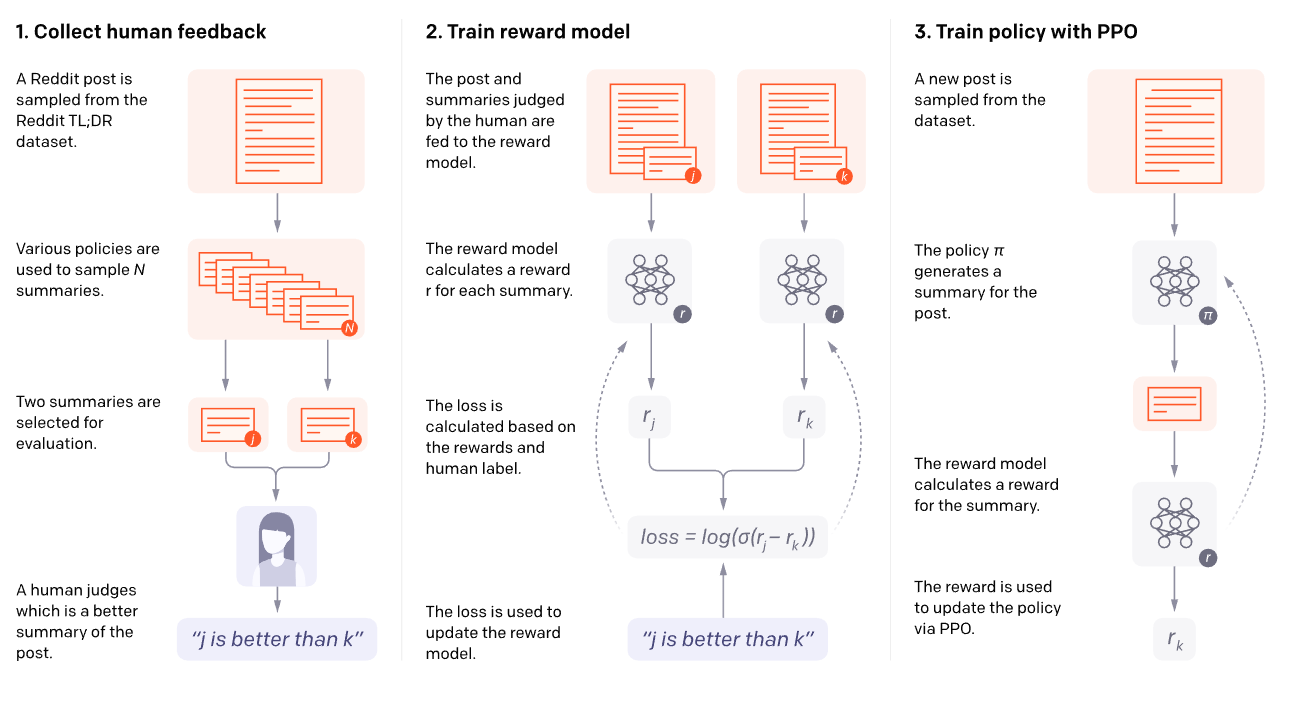

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure2.PNG', width="1000") 

### Collect human feesback

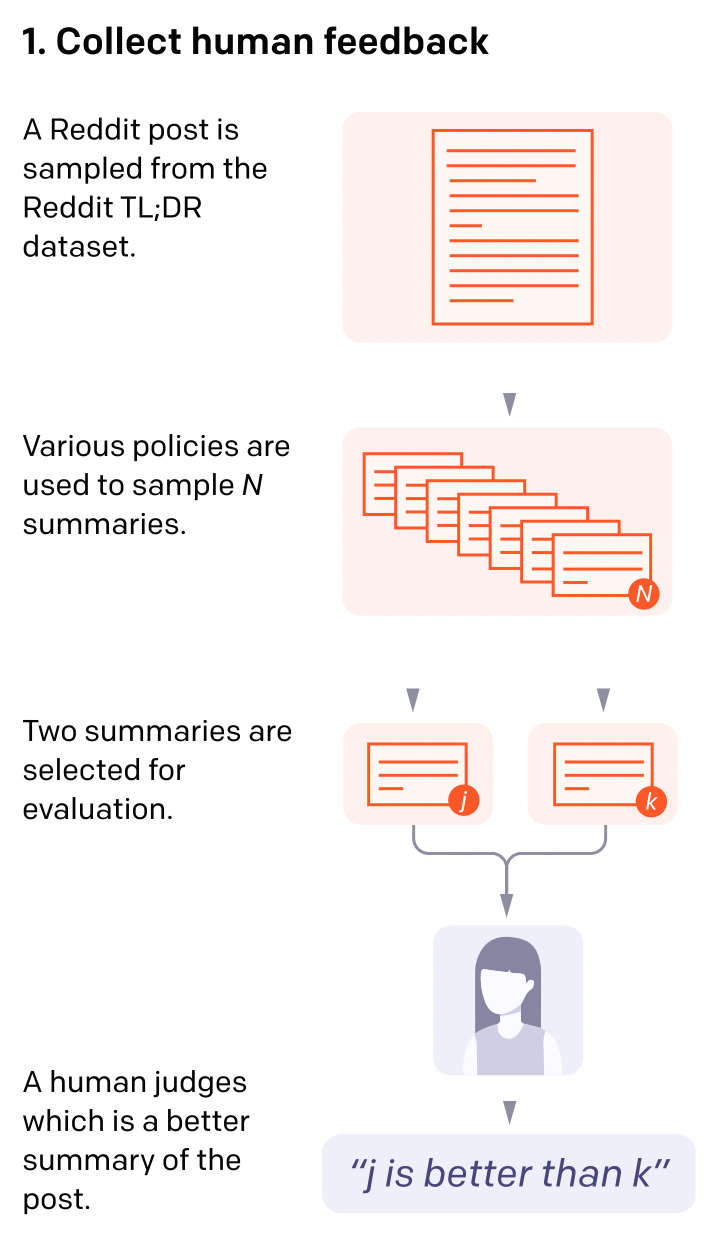

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure5.png', width="300") 

https://openaipublic.blob.core.windows.net/summarize-from-feedback/website/index.html#/tldr_comparisons

**Dataset:** The authors used a dataset of **3 million posts from the website reddit.com**, along with summary descriptions of the posts written by the original poster. **They filtered the dataset** to ensure quality, including using a whitelist of subreddits that are **understandable** to the general population and including only posts where the human-written summaries contain between 24 and 48 tokens to minimize the potential effect of **summary length** on quality. The **final filtered dataset contains 123,169 posts** and they held out 5% as a validation set. They will refer to this dataset as "TL;DR" throughout the rest of the paper.

**Labelers:** The paper describes problem a **known problem** of mismatch between the intended quality of the model and what human labelers evaluated, which results in model-generated summaries that were **high-quality according to labelers but low-quality according to researchers**. To improve human data quality, the authors of the paper propose to establish a hands-on relationship with labelers. They give **detailed instructions**, answer questions and provide **regular feedbacks**. The researchers train labelers to ensure high agreement with their judgments and continuously monitor agreement between labelers and researchers throughout the project. As a result of this, **they obtained high agreement between labelers and researchers** on a subset of comparison tasks, labelers agree with researchers 77% ± 2% of the time, while researchers agree with each other 73% ± 4% of the time.

**Policies:** The authors generete summaries by several different summarization policies. These include:

* **Title:** This policy involves using the title of the text as a summary, which is a common practice in summarization as the title is often thought to convey the main idea of the text.

* **Lead-2:** This policy involves using the first 2 sentences of the text as a summary. These two sentences are often used as a lead in news articles and are thought to convey the main idea of the text.

* **Reference Summary:** This policy involves using the human-written summary of the text as the summary. These are summaries written by the original poster of the text which are labeled as 'TL;DR' in the dataset.

* **Pretrain-only:** This policy involves using a transformer model that is only pretrained on a large text corpus and use it to autoregressively predict the next token, then use these models as a 'zero-shot' baselines by padding the context with examples of high-quality summaries from the dataset.

* **Supervised learning:** This policy involves fine-tuning the transformer model with supervised learning to predict summaries from the filtered TL;DR dataset. These models are then used to sample initial summaries for collecting comparisons and as baselines for evaluation

### Train reward model

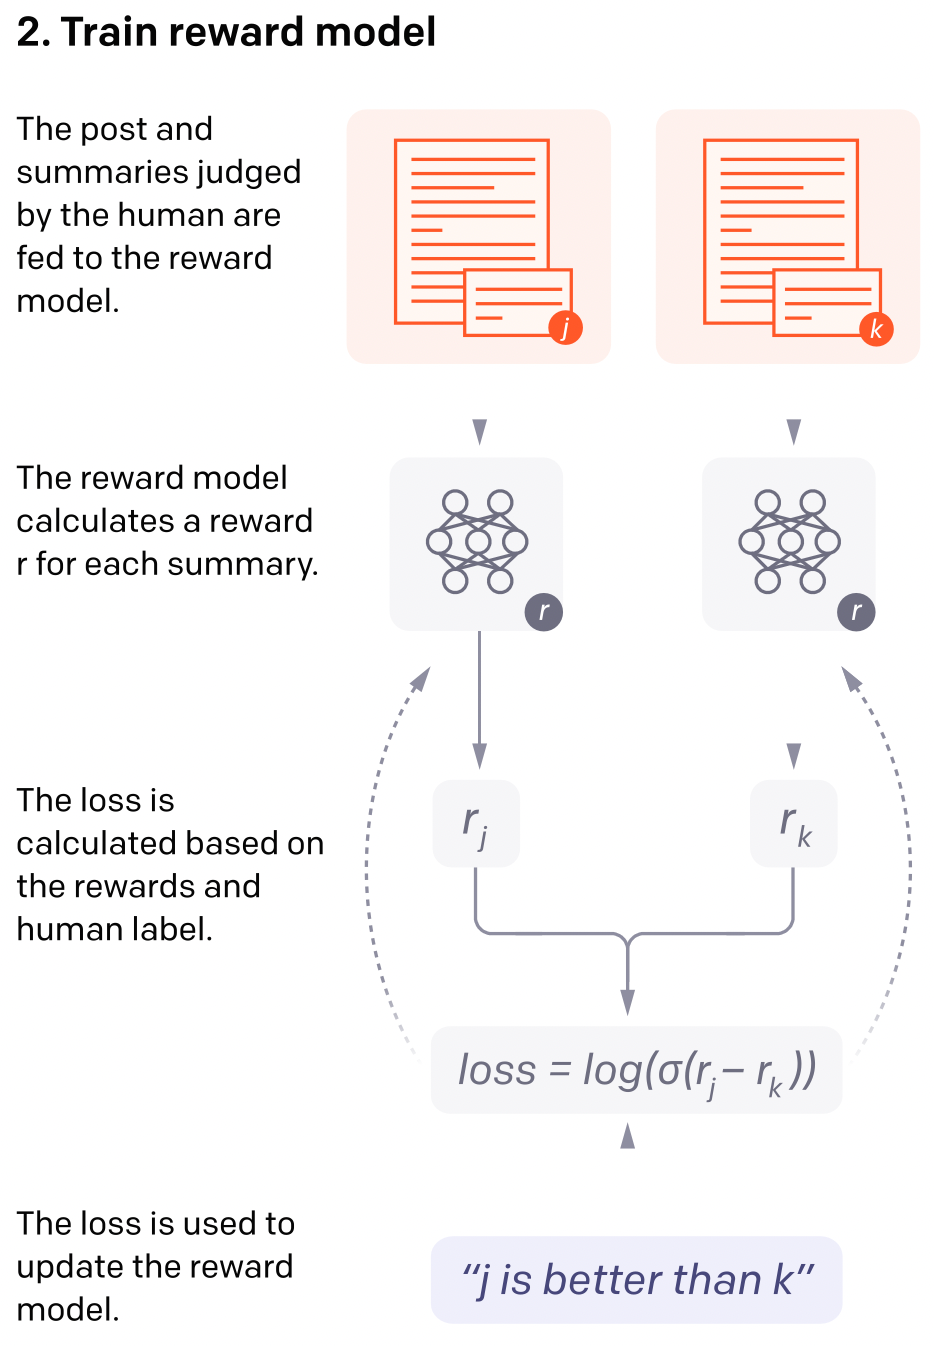

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure6.png', width="300") 

**Reward Model (RM):** RM is a machine learning model that is trained on a filtered dataset of text and corresponding human-written summaries. It uses supervised learning to predict which of two given summaries is better.**The input to the RM is a post and the two summaries judged by the human, and the output is a scalar values** that represents the predicted quality of the summaries. The RM is trained by fine-tuning it on a supervised dataset, then adding a randomly initialized linear head to the model, and training it to predict which summary is better as judged by a human. This trained RM is later used as the reward signal in the human feedback policy training process to generate higher-quality outputs as judged by humans.

**Loss Function:** The reward model was trained to predict which summary $y∈{y0, y1}$ is better as judged by a human, given a post x. If the summary preferred by the human is: $y_i$, the RM loss is:<br><br>**$loss(r_Θ)=-E(x,y_o,y_1,i)$~$D[log(σ(r_Θ(x,y_i)-r_Θ(x,y_1-i)))]$**<br><br>where $r_θ(x, y)$ is the scalar output of the reward model for post x and summary y with parameters θ, and D is the dataset of human judgments. In order to **minimize the loss** we would want to **maximize the difference between the rewards** assigned to two summaries, with the **preferred summary receiving a higher reward** and the other receiving a lower reward.

### Train policy with PPO

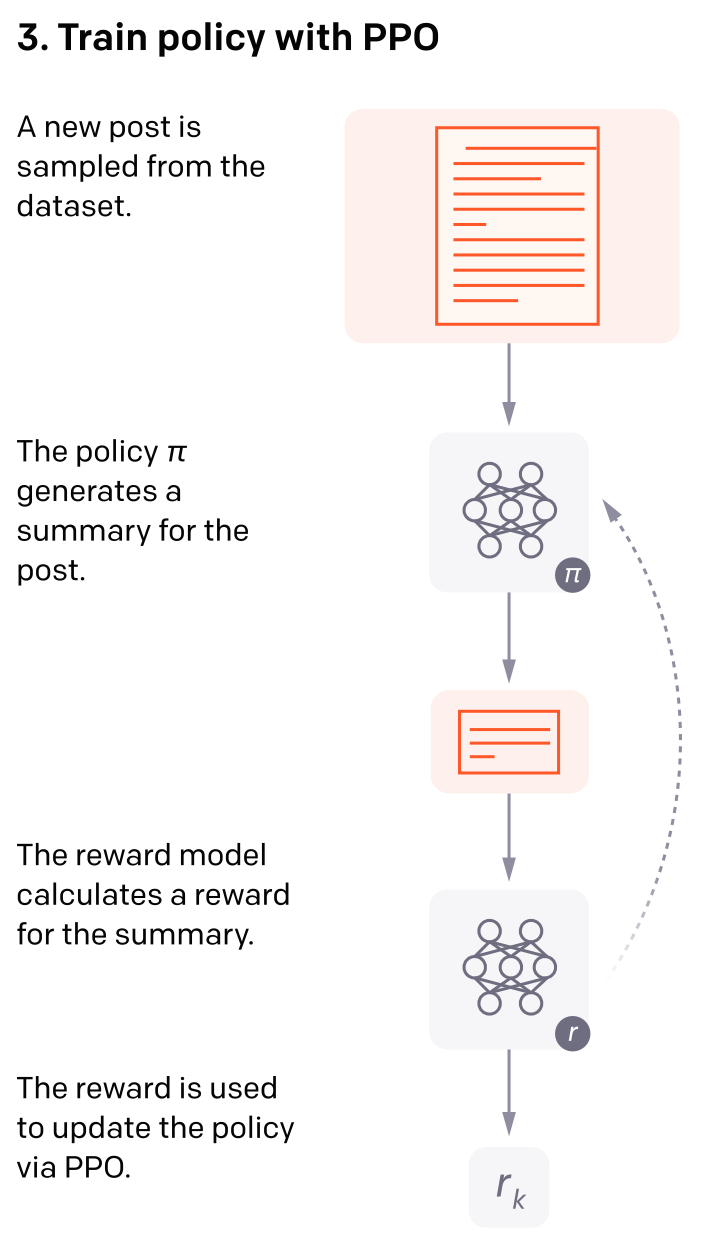

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure7.png', width="300") 

**RL Overview:** In reinforcement learning, an **agent learns by interacting with an environment**, in order to **maximize a reward signal**. At each step, the agent receives an observation of the state of the environment and takes an action. The action results in a change in the state of the environment, and the agent receives a reward signal. The goal of the agent is to **learn a policy that maximizes the expected cumulative reward over time**. The agent learns through **trial and error**, using feedback from the environment in the form of the reward signal. It adjusts its actions based on this feedback, in order to increase the reward signal it receives. This process is called learning by reinforcement, because the agent is **reinforced with a positive signal** when it takes actions that lead to good outcomes.

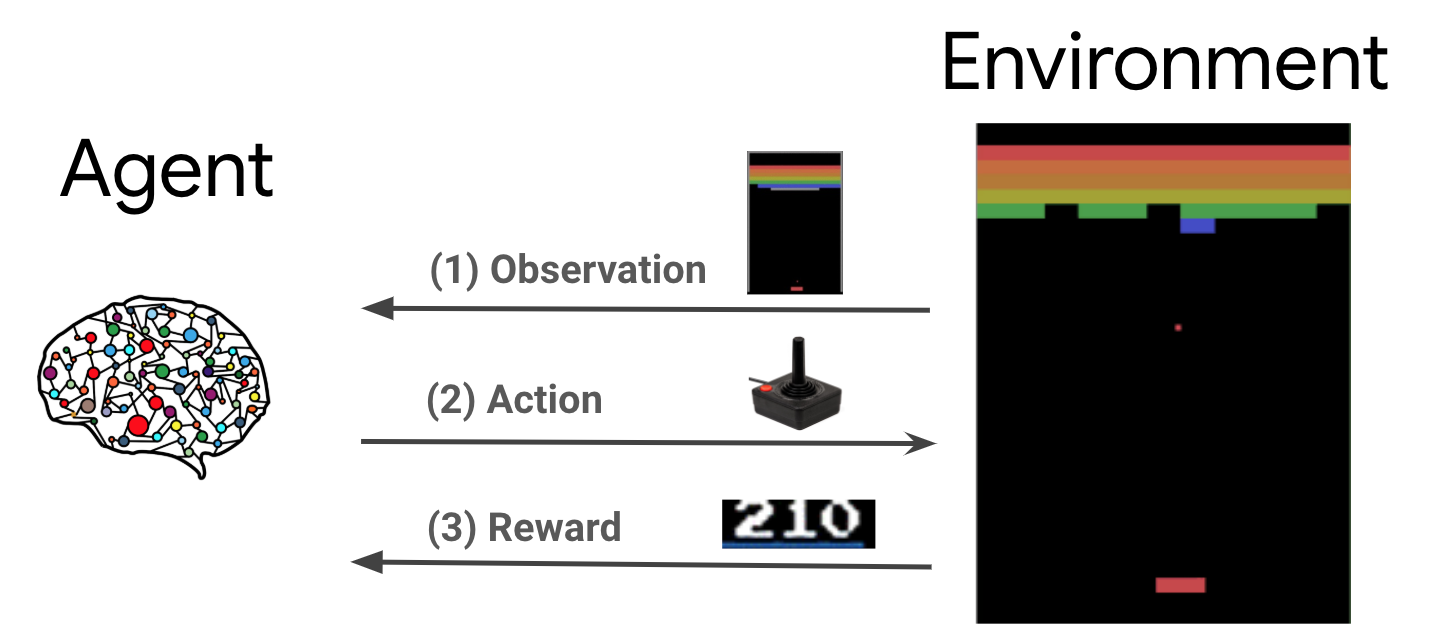

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure12.PNG', width="600") 

Policy example:

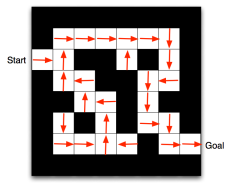

In [7]:
Image(filename='/content/drive/MyDrive/language_models/figure13.PNG', width="400")

**Agent Example:** https://www.youtube.com/watch?v=hJLmXezsjcg

**Play Atari Games:** In the paper "Playing Atari with Deep Reinforcement Learning" the authors presents a method for training a machine learning model to play Atari video games using deep reinforcement learning. The authors demonstrate that a deep neural network can be trained to learn how to play a variety of Atari games by interacting with the game environment and receiving feedback in the form of a **reward signal based on the game scor**e. The authors show that their approach is effective at learning to play Atari games and that the model is able to **learn directly from raw pixel inputs and a scalar reward signal**. This work was an important step in the development of deep reinforcement learning and has had a significant impact on the field.

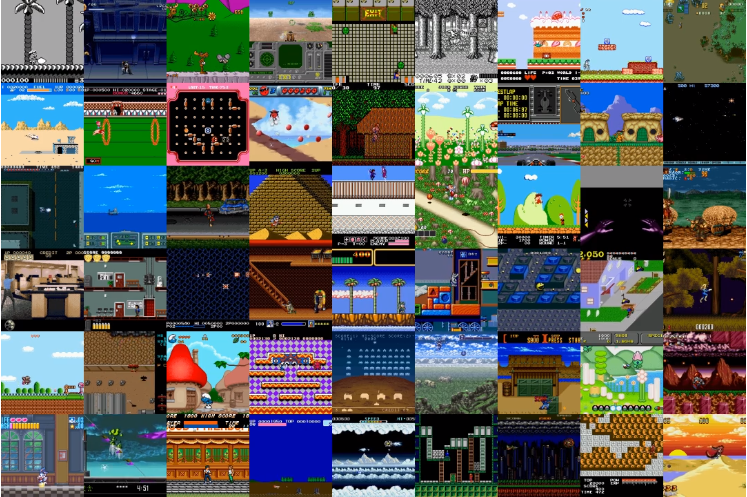

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure4.PNG', width="600") 

**Proximal Policy Optimization:** PPO has become the default reinforcement learning algorithm at OpenAI because of its ease of use and good performance. It has several key characteristics. Some of these include:

* **On-policy learning:** PPO is an on-policy algorithm, which means that it uses the current policy to generate data for the agent to learn from. This makes it more stable and sample efficient than off-policy algorithms.

* **Continuous action spaces:** PPO is designed to work well in environments with continuous action spaces, such as robotic control or game playing. It addresses the difficulty of optimizing a policy in such spaces by using a surrogate objective function that is optimized instead of the true objective.

* **Clipped Surrogate Objective:** In PPO the policy update uses a "clipped" objective function which prevents the update step from going too far away from the previous policy. This makes the update more stable and helps avoid overshooting the optimal policy.

* **Trust Region Method:** PPO uses a trust region method to update the policy, where it will only make a change if it improves the objective by more than a certain amount. This helps prevent the policy from making large, unnecessary updates that could make it worse.

* **Adaptive KL Penalty:** PPO uses a penalty term in the loss function for the KL divergence between the current policy and the old one, this prevents the policy to shift too far from the old one which makes it more stable and sample efficient

* **Value Function:** PPO uses a separate value function that estimates the expected return of each state, it uses this value function to estimate the quality of the policy update, this helps the agent to avoid suboptimal solutions.

Information regarding the PPO **loss function** can be found in: https://huggingface.co/blog/deep-rl-ppo

### Results

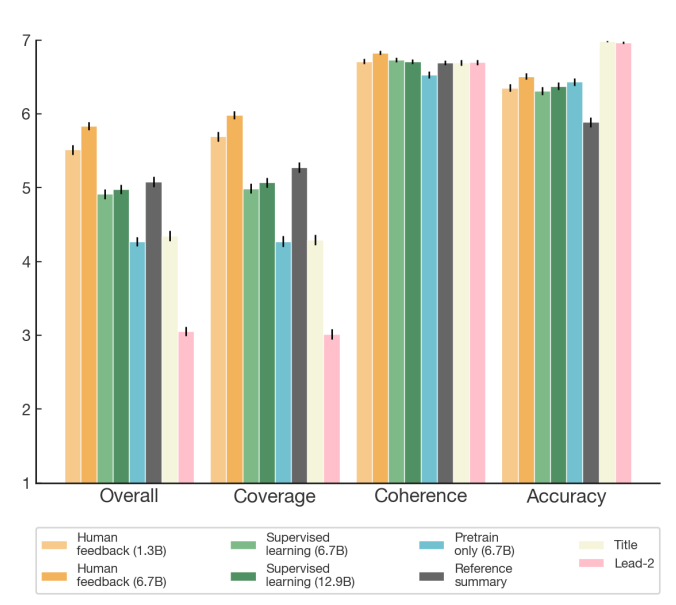

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure9.PNG', width="600")

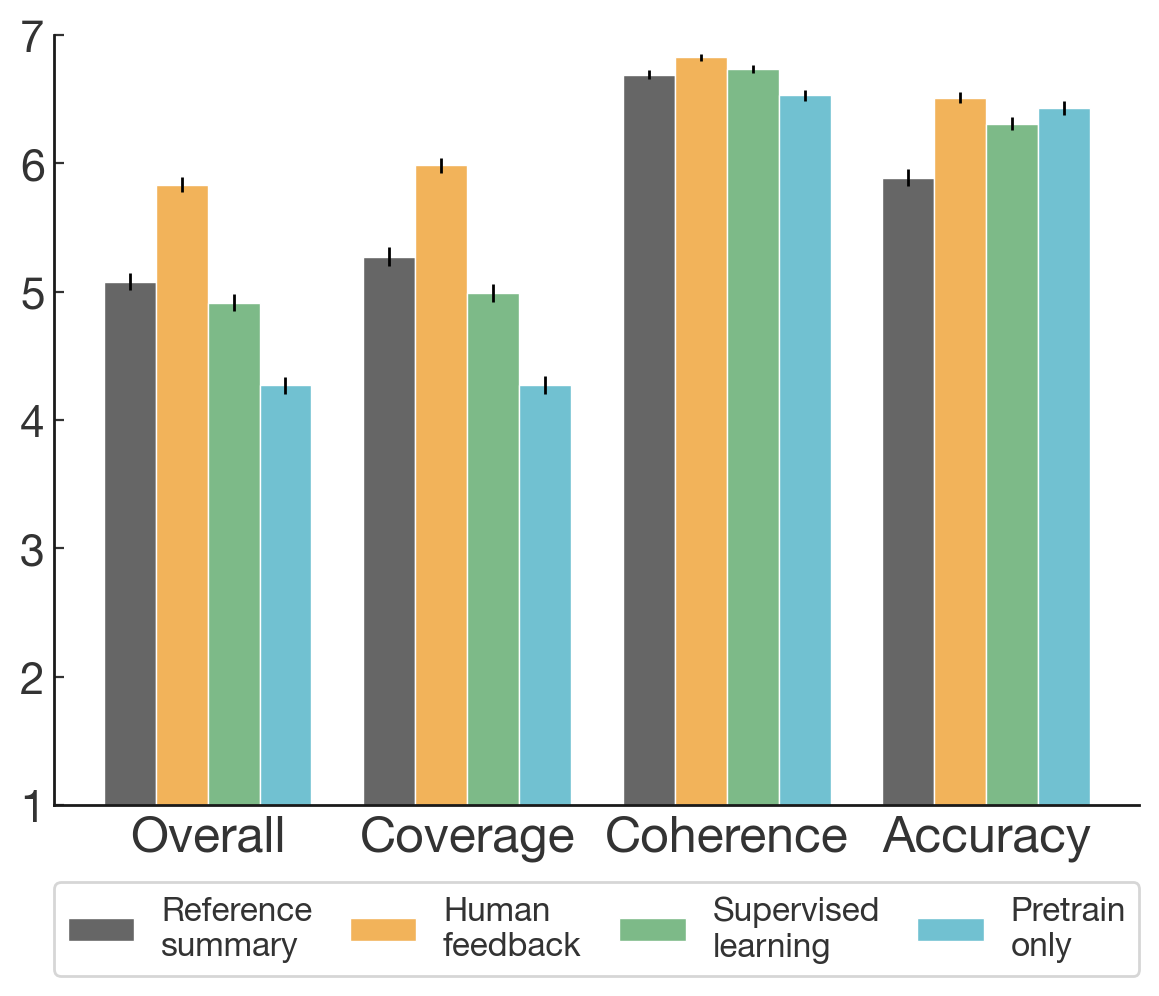

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure0.png', width="500")

From the charts, it can be inferred that the results of the "human feedback" model are superior to those of all other models.

### ChatGPT

It is worth noting that ChatGPT employs similar techniques, including training a reward model, ranking outputs by a labeler, and utilizing the Reinforcement Learning PPO algorithm to enhance the policy, resulting in improved output.

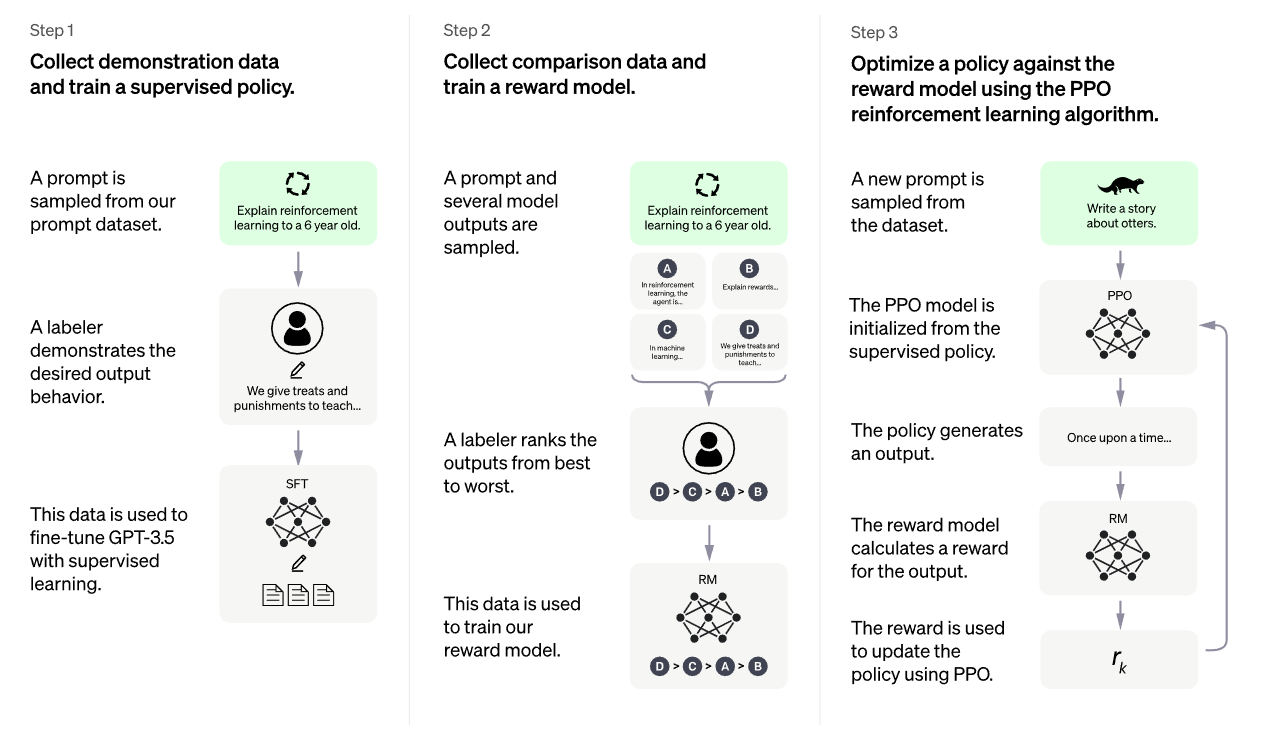

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure8.PNG', width="1000")

## Generate controlled sentiment reviews

### hyperparameters

In [ ]:
config = {
    "lm_name": "lvwerra/gpt2-imdb",
    "ref_lm_name": "lvwerra/gpt2-imdb",
    "cls_model_name": "lvwerra/distilbert-imdb",
    "tk_name": "gpt2",
    "steps": 25600,
    "batch_size": 128,
    "forward_batch_size": 8,
    "ppo_epochs": 4,   
    "txt_in_len": 5,
    "txt_out_len": 20,
    "lr": 1.41e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
    "seed": 1,
}

In [ ]:
np.random.seed(config['seed'])

In [ ]:
import wandb
wandb.init(name='long-response', project='gpt2-ctrl', config=config)

### IMDB Dataset

In [ ]:
# load imdb with datasets
ds = load_dataset('imdb', split='train')
ds = ds.rename_columns({'text': 'review', 'label': 'sentiment'})
ds.set_format('pandas')
df = ds[:]

# make sure the comments are long enough
df = df.loc[df['review'].str.len() > 500]

# make sure comments are not too long
df['review'] = df['review'].apply(lambda x: x[:1000])

df.head()

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


review  sentiment
0  I rented I AM CURIOUS-YELLOW from my video sto...          0
1  "I Am Curious: Yellow" is a risible and preten...          0
2  If only to avoid making this type of film in t...          0
3  This film was probably inspired by Godard's Ma...          0
4  Oh, brother...after hearing about this ridicul...          0

### Sentiment model

In [ ]:
sentiment_model = AutoModelForSequenceClassification.from_pretrained(config["cls_model_name"])
sentiment_tokenizer = AutoTokenizer.from_pretrained(config["cls_model_name"])

Downloading:   0%|          | 0.00/735 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

In [ ]:
text = 'this movie was really bad!!'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.3350, -2.7266]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
text = 'this movie was really good!!'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[-2.2948,  2.5570]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
text = 'this movie was a documentary'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[-0.7086,  0.8563]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The resulting reward signal:

In [ ]:
output[0][:, 1]

tensor([0.8563], grad_fn=<SelectBackward0>)

### GPT model and tokenizer

In [ ]:
gpt2_model = GPT2HeadWithValueModel.from_pretrained(config['lm_name'])
gpt2_model_ref = GPT2HeadWithValueModel.from_pretrained(config['ref_lm_name'])
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(config['tk_name'])

Downloading:   0%|          | 0.00/577 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at lvwerra/gpt2-imdb and are newly initialized: ['transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'v_head.summary.weight', 'v_head.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2HeadWithValueModel were not initialized from the model checkpoint at lvwerra/gpt2-imdb and are newly initialized: ['transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.3.attn.masked_

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
_ = gpt2_model.to(device)
_ = sentiment_model.to(device)
_ = gpt2_model_ref.to(device)

In [ ]:
wandb.watch(gpt2_model, log='all')

[]

In [ ]:
df['tokens'] = df['review'].progress_apply(lambda x: gpt2_tokenizer.encode(' '+x, return_tensors="pt").to(device)[0, :config['txt_in_len']])



  0%|          | 0/22578 [00:00<?, ?it/s]

  0%|          | 34/22578 [00:00<01:07, 334.80it/s]

  0%|          | 81/22578 [00:00<00:54, 410.91it/s]

  1%|          | 133/22578 [00:00<00:48, 460.13it/s]

  1%|          | 183/22578 [00:00<00:47, 474.55it/s]

  1%|          | 241/22578 [00:00<00:43, 509.88it/s]

  1%|▏         | 303/22578 [00:00<00:40, 544.96it/s]

  2%|▏         | 362/22578 [00:00<00:39, 556.10it/s]

  2%|▏         | 421/22578 [00:00<00:39, 565.43it/s]

  2%|▏         | 478/22578 [00:00<00:40, 545.22it/s]

  2%|▏         | 534/22578 [00:01<00:40, 548.62it/s]

  3%|▎         | 591/22578 [00:01<00:39, 554.32it/s]

  3%|▎         | 657/22578 [00:01<00:37, 584.20it/s]

  3%|▎         | 724/22578 [00:01<00:35, 607.36it/s]

  3%|▎         | 785/22578 [00:01<00:36, 600.45it/s]

  4%|▍         | 852/22578 [00:01<00:35, 620.17it/s]

  4%|▍         | 915/22578 [00:01<00:35, 614.59it/s]

  4%|▍         | 985/22578 [00:01<00:33, 638.85it/s]

  5%|▍         | 1052/22578 [00:01<00:3

In [ ]:
df['query'] = df['tokens'].progress_apply(lambda x: gpt2_tokenizer.decode(x))



  0%|          | 0/22578 [00:00<?, ?it/s]

 11%|█         | 2539/22578 [00:00<00:00, 25384.40it/s]

 22%|██▏       | 5078/22578 [00:00<00:00, 24455.31it/s]

 34%|███▍      | 7650/22578 [00:00<00:00, 25017.72it/s]

 46%|████▌     | 10299/22578 [00:00<00:00, 25590.61it/s]

 58%|█████▊    | 13041/22578 [00:00<00:00, 26243.81it/s]

 69%|██████▉   | 15668/22578 [00:00<00:00, 26149.35it/s]

 81%|████████  | 18304/22578 [00:00<00:00, 26217.55it/s]

100%|██████████| 22578/22578 [00:00<00:00, 25908.78it/s]


### Define sentiment tasks

In [ ]:
ctrl_str = ['[negative]', '[neutral]', '[positive]']

ctrl_tokens = dict((s, gpt2_tokenizer.encode(s, return_tensors="pt").squeeze().to(device)) for s in ctrl_str)

In [ ]:
ctrl_tokens

{'[negative]': tensor([   58, 31591,    60], device='cuda:0'),
 '[neutral]': tensor([   58, 29797,    60], device='cuda:0'),
 '[positive]': tensor([   58, 24561,    60], device='cuda:0')}

### Loss function

In [ ]:
def pos_logit_to_reward(logit, task):
    """
    Take the positive sentiment logit and scale it for the task.
        task [negative]: reward = -logit
        task [neutral]: reward = -2*abs(logit)+4
        task [positive]: reward = logit
    """
    for i in range(len(logit)):
        if task[i]=='[negative]':
            logit[i] = -logit[i]
        elif task[i]=='[neutral]':
            logit[i] = -2*torch.abs(logit[i])+4
        elif task[i]=='[positive]':
            pass
        else:
            raise ValueError('task has to be in [0, 1, 2]!')
    return logit

Examples for inputs and outputs for pos_logit_to_reward function:

In [ ]:
print(ctrl_str)

['[negative]', '[neutral]', '[positive]']


In [ ]:
pos_logit_to_reward(torch.Tensor([4,4,4]), ctrl_str)

tensor([-4., -4.,  4.])

For the negative task, and a positive sentiment of 4, the reward will be -4 (negative reward).<br>For the neutral task, and a positive sentiment of 4, the reward will be -4 (negative reward).<br>For the positive task, and a positive sentiment of 4, the reward will be 4 (positive reward), as the sentiment is aligned with the task.

In [ ]:
pos_logit_to_reward(torch.Tensor([-4,-4,-4]), ctrl_str)

tensor([ 4., -4., -4.])

For the negative task, and a negative sentiment of -4, the reward will be 4 (positive reward), as the sentiment is aligned with the task.<br>For the neutral task, and a negative sentiment of -4, the reward will be -4 (negative reward).<br>For the positive task, and a negative sentiment of -4, the reward will be -4 (negative reward).

In [ ]:
pos_logit_to_reward(torch.Tensor([0, 0, 0]), ctrl_str)

tensor([-0., 4., 0.])

For the negative task, and a neutral sentiment of 0, the reward will be 0.<br>For the neutral task, and a neutral sentiment of 0, the reward will be 4 (positive reward), as the sentiment is aligned with the task.<br>For the positive task, and a neutral sentiment of 0, the reward will be 0.

<br>It is important to note that the proposed reward system is a suggestion and can be modified and further studied in future research.

### Model Training

The training loop consists of the following steps:

* Get a batch of queries and create random controls
* Get the query responses from the policy
* Join query and responses and tokenize for BERT analysis
* Get sentiments for query/responses from BERT
* Optimize policy with PPO using the (query, response, reward) triplet
* Log all the training statistics

In [ ]:
ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, gpt2_tokenizer, **config)
fbs = config['forward_batch_size']

for epoch in tqdm(range(int(np.ceil(config["steps"]/config['batch_size'])))):
    torch.cuda.empty_cache()
    logs = dict()
    game_data = dict()
    timing = dict()
    t0 = time.time()
    
    #### get a batch from the dataset and annotate tasks
    df_batch = df.sample(config['batch_size'])
    task_list = choices(ctrl_str, k=config['batch_size'])
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])
    query_list = df_batch['query'].tolist()
    game_data['query'] = [t+q for t,q in zip(task_list, query_list)]
    
    query_tensors = torch.stack(df_batch['tokens'].tolist())
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)
    
    #### get response from gpt2
    t = time.time()
    response_tensors = []
    for i in range(int(config['batch_size']/fbs)):
        response  = respond_to_batch(gpt2_model, query_tensors[i*fbs:(i+1)*fbs],
                                     txt_len=config['txt_out_len'])
        response_tensors.append(response)
    response_tensors = torch.cat(response_tensors)
    game_data['response'] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(config['batch_size'])]
    timing['time/get_response'] = time.time()-t

    #### tokenize text for sentiment analysis
    t = time.time()
    texts = [q + r for q,r in zip(query_list, game_data['response'])]
    sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, sentiment_tokenizer, device)    
    timing['time/build_input_sentiment'] = time.time()-t

    #### get sentiment score
    t = time.time()
    pos_logits = []
    for i in range(int(config['batch_size']/fbs)):
        res = sentiment_model.forward(sentiment_inputs[i*fbs:(i+1)*fbs],
                                      attention_masks[i*fbs:(i+1)*fbs])[0][:, 1].detach()
        pos_logits.append(res)
    rewards = pos_logit_to_reward(torch.cat(pos_logits), task_list)
    timing['time/get_sentiment_preds'] = time.time()-t

    #### Run PPO training 
    t = time.time()
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    timing['time/optimization'] = time.time()-t
     
    #### Log everything
    timing['time/epoch'] = time.time()-t0
    table_rows = [list(r) for r in zip(game_data['query'], game_data['response'], rewards.cpu().tolist())]
    logs.update({'game_log':wandb.Table(
        columns=['query', 'response', 'reward'],
        rows=table_rows)})
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()
    for ctrl_s in ctrl_str:
        key = 'env/reward_'+ctrl_s.strip('[]')
        logs[key] = np.mean([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s])
    wandb.log(logs)

  0%|          | 0/200 [00:00<?, ?it/s]wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
 75%|███████▌  | 150/200 [3:18:20<1:05:44, 78.89s/it]

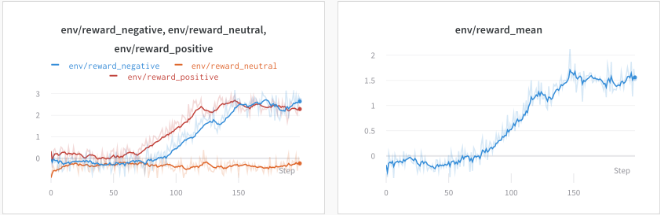

In [ ]:
Image(filename='/content/drive/MyDrive/language_models/figure11.PNG', width="600")

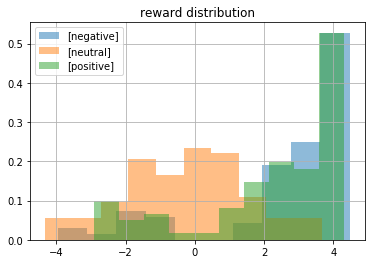

In [ ]:
for ctrl_s in ctrl_str:
    plt.hist([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s],
             density=True,
             alpha=0.5,
             label=ctrl_s)
plt.legend(loc='best')
plt.title('reward distribution')
plt.grid(True)
plt.show()

### Results Overview

In [ ]:
#### get a batch from the dataset
bs = 32
game_data = dict()
df_batch = df.sample(bs)
query_list = df_batch['query'].tolist()
game_data['query'] = query_list
for ctrl in ctrl_str:
    task_list = [ctrl] * bs
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])

    query_tensors = torch.stack(df_batch['tokens'].tolist())
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)

    #### get response from gpt2 and gpt2_ref
    response_tensors  = respond_to_batch(gpt2_model, query_tensors, txt_len=config['txt_out_len'])
    game_data['response ' + ctrl] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(bs)]

    #### sentiment analysis of query/response pairs before/after
    texts = [q + r for q,r in zip(game_data['query'], game_data['response ' + ctrl])]
    sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, sentiment_tokenizer, device)    
    rewards = sentiment_model.forward(sentiment_inputs, attention_masks)[0][:, 1].detach()
    game_data['rewards ' + ctrl] = pos_logit_to_reward(rewards, task_list).cpu().numpy()

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

query  \
0               As a Pokémon fan I   
1        I watched this movie when   
2       Not even the Beatles could   
3                    In 1993, "the   
4               I like this movie.   
5                    ***SPOILER AL   
6               This is one of the   
7       I can remember seeing this   
8       Underneath the dense green   
9         I know it is fashionable   
10        Once big action star who   
11         Although it strays away   
12              The retelling of a   
13          An unflinching descent   
14          I readily admit that I   
15               Red Skelton plays   
16         Read a biography of the   
17       This film is a delightful   
18   From the opening scene aboard   
19     Brothers with psychokinetic   
20                "Black Water" is   
21            I sort of liked this   
22       I'm rather surprised that   
23                **May Contain Sp   
24     In an otherwise good review   
25                   Andaz Apna Ap   
26             As part of our late   
27         This is the first movie   
28          This 1970 hit film has   
29            Kevin Kline offers a   
30       I rented this film purely   
31              Very nice movie! I   

                                  response [negative]  rewards [negative]  \
0    Neanderthal and wish to make the reverse abou...            2.377694   
1    it was released and was awful. Little bit of ...            3.130034   
2    cover this rubbish! This is one of the worst ...            4.472919   
3    filmmaker" turned up in a bad movie. This is ...            3.461677   
4    It is one of the worst movies I have ever see...           -0.557796   
5   ERT***<br /><br />This movie is one of the wor...            4.379598   
6    worst movies I have ever seen. I had seen the...            4.363608   
7    movie in 2008, and I was so disappointed...yo...            3.428725   
8    line is a trio of cardboard skeletons (actual...           -0.000704   
9    at this site but it is truly hopelessly wrong...            4.004134   
10   got bored by his initial appearance as a mons...            2.178412   
11   from the madness of a terrible movie. Any of ...            0.569968   
12   really bad movie I saw there was very poor ac...            3.633320   
13   of Kristopher, we see a hopeless cycle caused...           -2.040538   
14  'mnot the type of horror fan I'd like to see s...            2.642914   
15   the young oscar. This is one of the worst mov...            4.278336   
16   doomed director and six writers. This is defi...            4.472337   
17   giveaway that prevents people from watching i...           -1.821272   
18   the faulty shuttle, in addition, there is "fl...           -1.504807   
19   weapons. Adding the "required" part for the f...            2.234411   
20   a bad movie, but anyway I recorded the film i...            3.709328   
21   movie because they were so outrageous. The sc...            2.610191   
22   this movie is so bad for time. it actually ma...            4.024343   
23  oilers, films that have some flaws, like point...           -1.093829   
24  , writing this is the worst film I have ever r...            3.914181   
25  hom Singh - worse than anyone here has seen. T...            4.286319   
26   decades, in spite of the fact that this film ...           -2.584670   
27   to end, but it is supposed to be the worst mo...            3.063779   
28   little resonance. This movie is bad, not only...            4.241872   
29   total of 5 philosophical warnings that beings...            2.044270   
30   on financial justification. Most conversation...            2.637776   
31   already saw it already and have never seen it...           -4.169400   

                                   response [neutral]  rewards [neutral]  \
0    consider a lot of the explosions going throug...           2.443991   
1    it was released and it was the first movie I ...          -1.351991   
2   

In [ ]:
input_string = '[negative] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' is horrible and the story will exceed the failures. The ending is huge and what the viewers will fix'

In [ ]:
input_string = '[neutral] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' is quite opaque. There is a black elephant hunt, for example, and there is no time-'

In [ ]:
input_string = '[positive] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' is a thrilling collection of image and cinematography. The heavily underused photography is quite powerful. Everyone'

As it can be observed, the model managed to generate its reviews based on the assigned task successfully, which illustrates the concept of controlled text generation.

### Future Work

* Try different reward systems
* Further evaluate the results with known metrices
* Experiment on several new datasets
* Experiment with more exotic tasks
* Further explore the capability of ChatGPT to generalize to an infinite number of tasks based on the user input.





## Refrences

https://arxiv.org/pdf/2009.01325.pdf

https://openai.com/blog/learning-to-summarize-with-human-feedback/

https://machinelearning.co.il/8530/learning-to-summarize/

https://openai.com/blog/summarizing-books/

https://sh-tsang.medium.com/review-learning-to-summarize-from-human-feedback-d5bb11e4c1c5

https://openai.com/blog/instruction-following/#moon

https://openaipublic.blob.core.windows.net/summarize-from-feedback/website/index.html#/tldr_comparisons

https://openai.com/blog/openai-baselines-ppo/

https://huggingface.co/blog/deep-rl-ppo

https://openai.com/blog/chatgpt/

https://wandb.ai/ayush-thakur/RLHF/reports/Understanding-Reinforcement-Learning-from-Human-Feedback-RLHF-Part-1--VmlldzoyODk5MTIx

https://openai.com/blog/instruction-following/

https://github.com/openai/summarize-from-feedback/blob/master/model_card.md
